In [1]:
import os
import glob
import re
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.features import geometry_mask
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [14]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\island_by_island\\buch_image"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\island_by_island\\buch_train"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")

In [15]:
# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

In [16]:
# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

In [17]:
# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    # Extract island name and date from file name
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue
    
    # Find corresponding shapefile
    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue
    
    # Only one matching shapefile for each image
    shapefile_path = matching_shapefiles[0]
    
    # Add the pair to the dictionary
    file_pairs[image_path] = shapefile_path

# Print the paired files to verify
for image_path, shapefile_path in file_pairs.items():
    print(f"Image: {image_path} | Shapefile: {shapefile_path}")


Image: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\buch_image\buch_20230714_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\buch_train\buch_20230714_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\buch_image\buch_20230720_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\buch_train\buch_20230720_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\buch_image\buch_20230731_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\buch_train\buch_20230731_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\buch_image\buch_20230923_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\buch_train\buch_20230923_train.shp


In [18]:
# Double check the shapefiles all have the same column names to avoid further issues 

import fiona

# Iterate through shapefile paths
for shapefile_path in shapefile_paths:
    # Open the shapefile
    with fiona.open(shapefile_path) as shp:
        # Print the column names
        print(f"Shapefile: {shapefile_path}")
        print("Column names:", shp.schema['properties'].keys())
        print()


Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\buch_train\buch_20230714_train.shp
Column names: dict_keys(['Id', 'label'])

Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\buch_train\buch_20230720_train.shp
Column names: dict_keys(['Id', 'label'])

Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\buch_train\buch_20230731_train.shp
Column names: dict_keys(['Id', 'label'])

Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\buch_train\buch_20230923_train.shp
Column names: dict_keys(['Id', 'label'])


In [19]:
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    
    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']
        
        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
    
    return np.array(features), np.array(labels)

features = []
labels = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)

features = np.vstack(features)
labels = np.hstack(labels)

In [20]:
# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)


In [21]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

In [22]:
# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [23]:
# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

  freshwater       0.90      0.88      0.89      6947
         ice       0.97      0.99      0.98     39010
       ocean       1.00      1.00      1.00     62835
        rock       0.93      0.82      0.87      1913
walrus_mixed       1.00      0.03      0.05        36

    accuracy                           0.98    110741
   macro avg       0.96      0.74      0.76    110741
weighted avg       0.98      0.98      0.98    110741


In [24]:
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model)


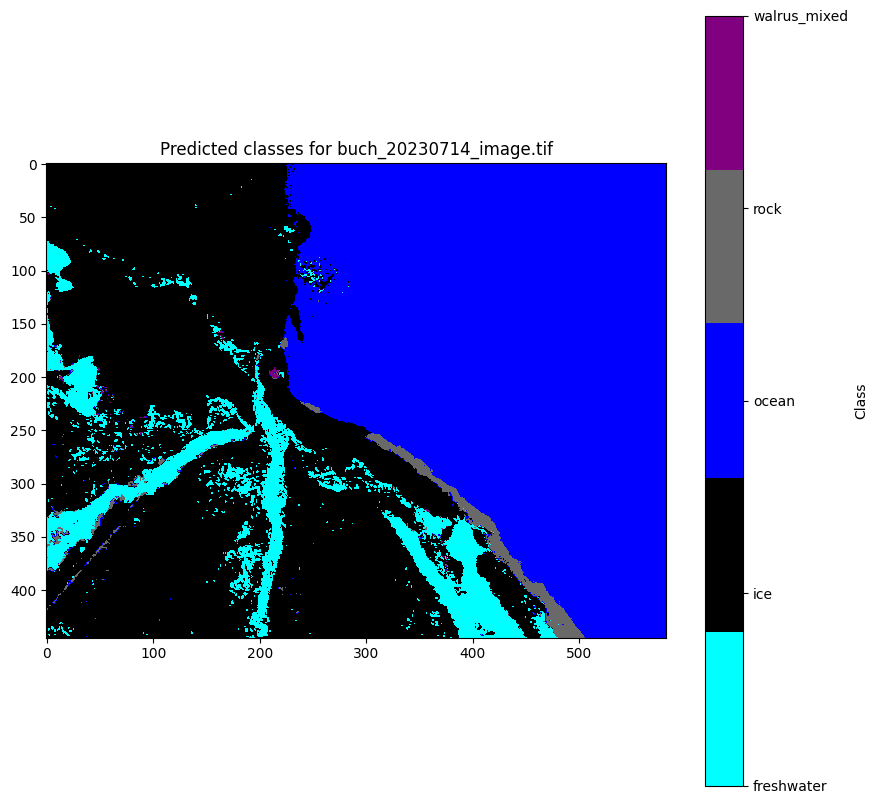

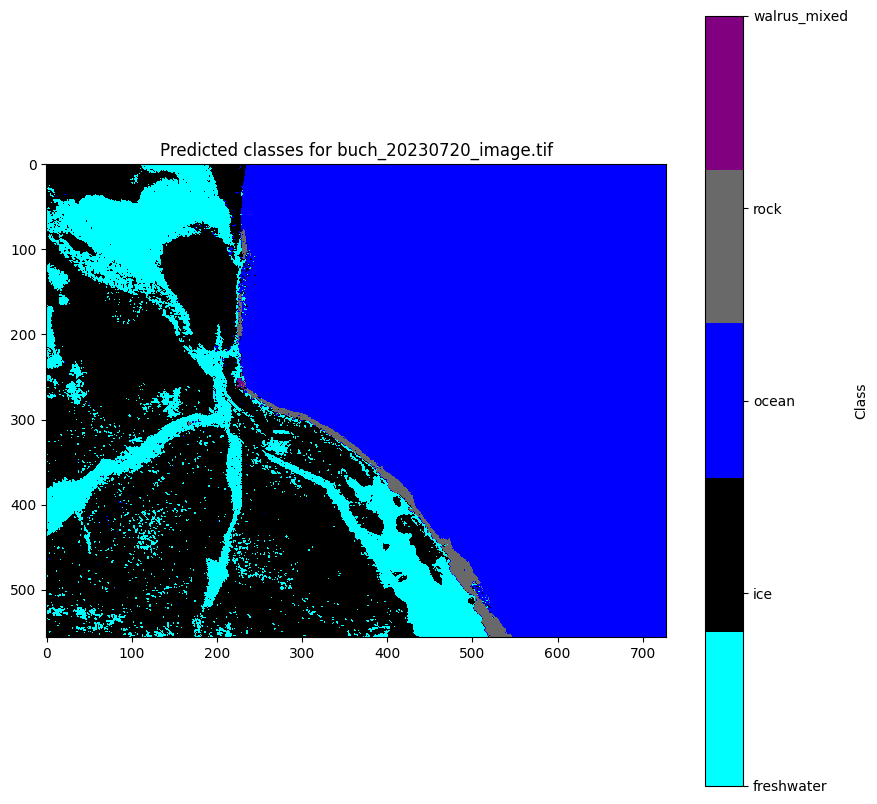

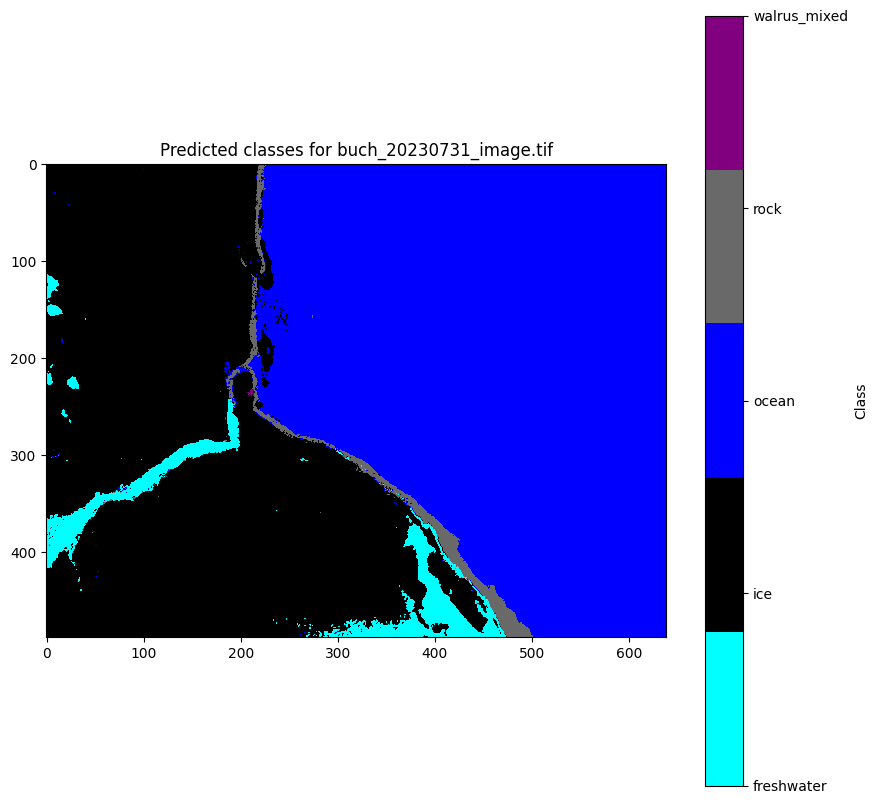

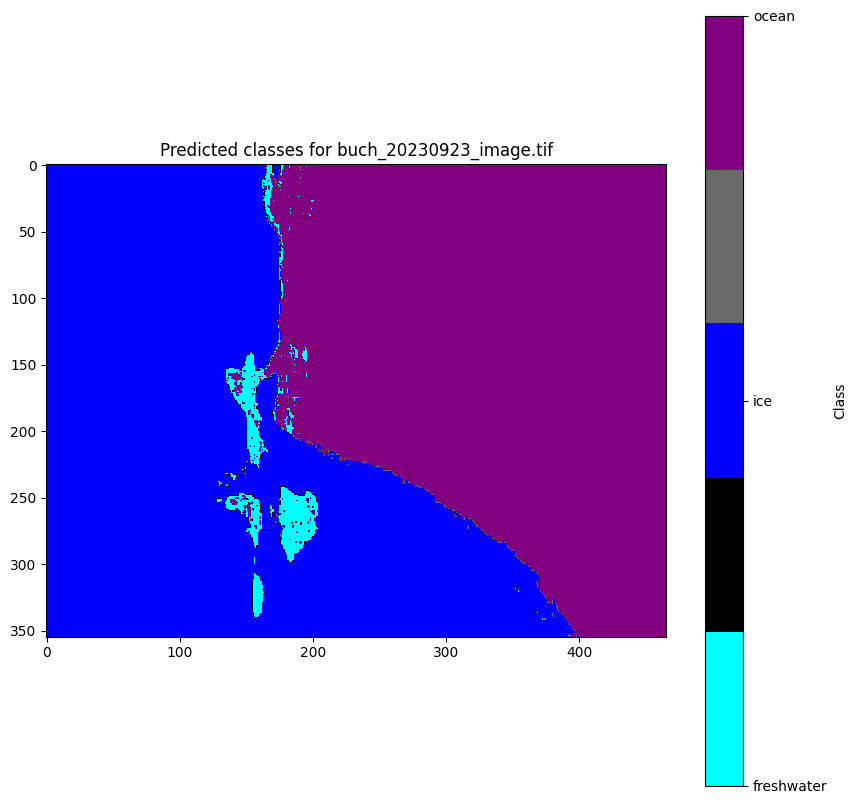

In [28]:
# Define a color map for the labels
label_colors = {'ice': 'black', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'purple', 'freshwater': 'cyan', 'ocean': 'blue'}
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap)
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
    plt.show()

The image above is not coloured properly becuase it has different labels, or more acuratley, does not contain the labels 'rock' and 'walrus_mixed' so the colour map needs to be adjusted. 

Labels present in buch_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


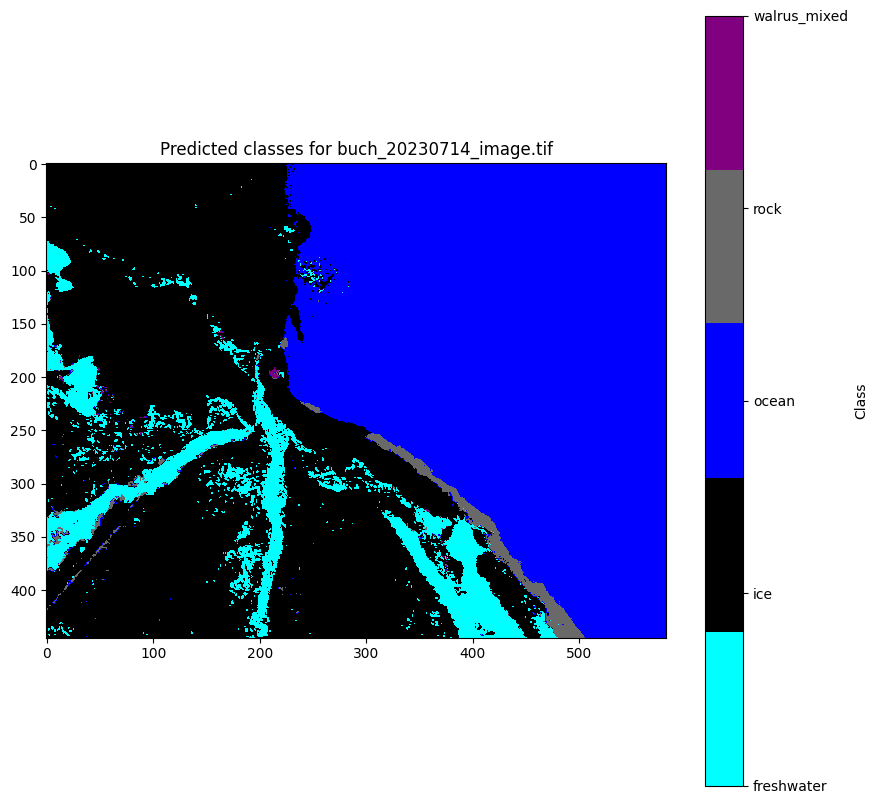

Labels present in buch_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


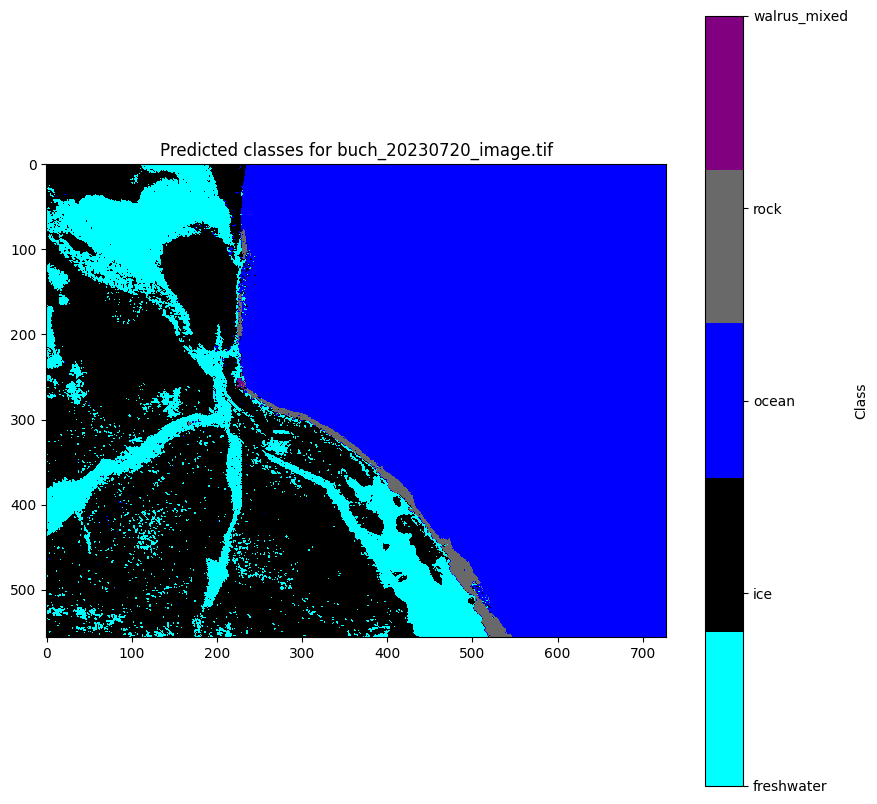

Labels present in buch_20230731_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


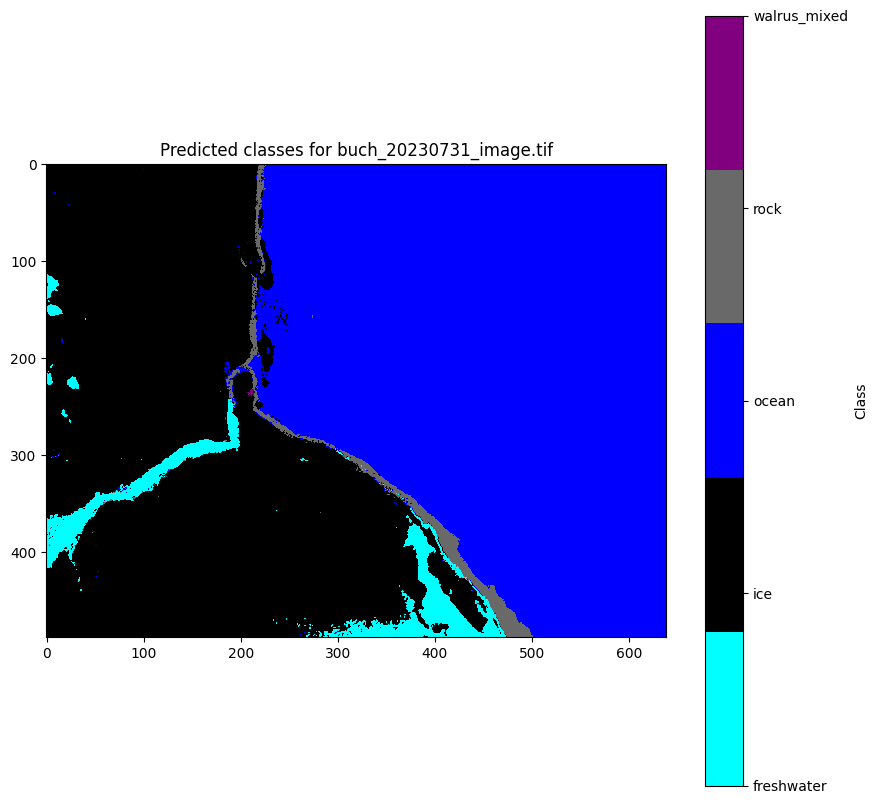

Labels present in buch_20230923_image.tif: ['freshwater', 'ice', 'ocean']


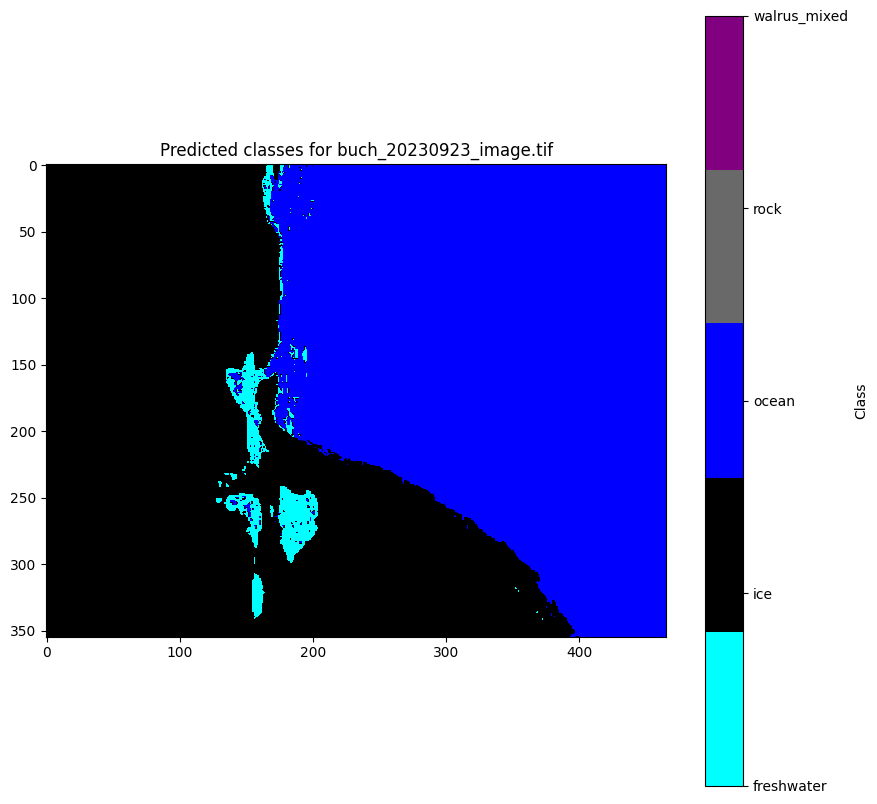

In [29]:
# Define a color map for the labels
label_colors = {'ice': 'black', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'purple', 'freshwater': 'cyan', 'ocean': 'blue'}
# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
    
    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()


MOFF

In [39]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\island_by_island\\moff_image"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\island_by_island\\moff_train"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")

In [40]:
# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

In [41]:
# Create a dictionary to store paired image and shapefile paths
file_pairs = {}

In [42]:
# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    # Extract island name and date from file name
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue
    
    # Find corresponding shapefile
    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue
    
    # Only one matching shapefile for each image
    shapefile_path = matching_shapefiles[0]
    
    # Add the pair to the dictionary
    file_pairs[image_path] = shapefile_path

# Print the paired files to verify
for image_path, shapefile_path in file_pairs.items():
    print(f"Image: {image_path} | Shapefile: {shapefile_path}")


Image: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\moff_image\moff_20230717_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\moff_train\moff_20230717_train.shp


In [43]:
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    
    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']
        
        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
    
    return np.array(features), np.array(labels)

features = []
labels = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)

features = np.vstack(features)
labels = np.hstack(labels)

In [44]:
# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)
# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [45]:
# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

  freshwater       1.00      0.74      0.85        54
         ice       0.99      1.00      1.00      2478
       ocean       1.00      1.00      1.00     10962
walrus_mixed       1.00      0.38      0.55         8

    accuracy                           1.00     13502
   macro avg       1.00      0.78      0.85     13502
weighted avg       1.00      1.00      1.00     13502


In [46]:
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model)


Labels present in moff_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'walrus_mixed']


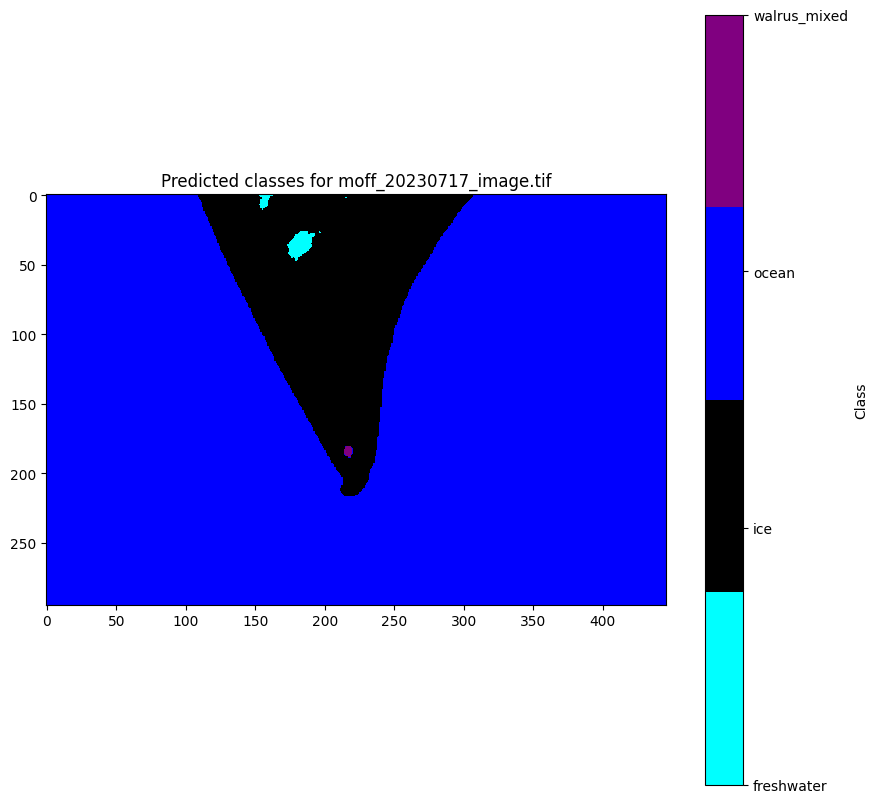

In [47]:
# Define a color map for the labels
label_colors = {'ice': 'black', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'purple', 'freshwater': 'cyan', 'ocean': 'blue'}
# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
    
    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()


In [60]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\island_by_island\\pal_image"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\island_by_island\\pal_train"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")

In [61]:

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None


# Create a dictionary to store paired image and shapefile paths
file_pairs = {}
# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    # Extract island name and date from file name
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    # Find corresponding shapefile
    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    # Only one matching shapefile for each image
    shapefile_path = matching_shapefiles[0]

    # Add the pair to the dictionary
    file_pairs[image_path] = shapefile_path

# Print the paired files to verify
for image_path, shapefile_path in file_pairs.items():
    print(f"Image: {image_path} | Shapefile: {shapefile_path}")

Image: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\pal_image\pal_20230714_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\pal_train\pal_20230714.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\pal_image\pal_20230720_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\pal_train\pal_20230720_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\pal_image\pal_20230726_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\pal_train\pal_20230726_train.shp


In [62]:
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    
    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']
        
        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
    
    return np.array(features), np.array(labels)

features = []
labels = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)

features = np.vstack(features)
labels = np.hstack(labels)

In [63]:
# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)
# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [64]:
# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

         ice       0.99      0.97      0.98      1920
       ocean       1.00      1.00      1.00     15577
        rock       0.99      1.00      1.00     16551
walrus_mixed       1.00      0.30      0.46        47

    accuracy                           1.00     34095
   macro avg       1.00      0.82      0.86     34095
weighted avg       1.00      1.00      1.00     34095


Labels present in pal_20230714_image.tif: ['ice', 'ocean', 'rock', 'walrus_mixed']


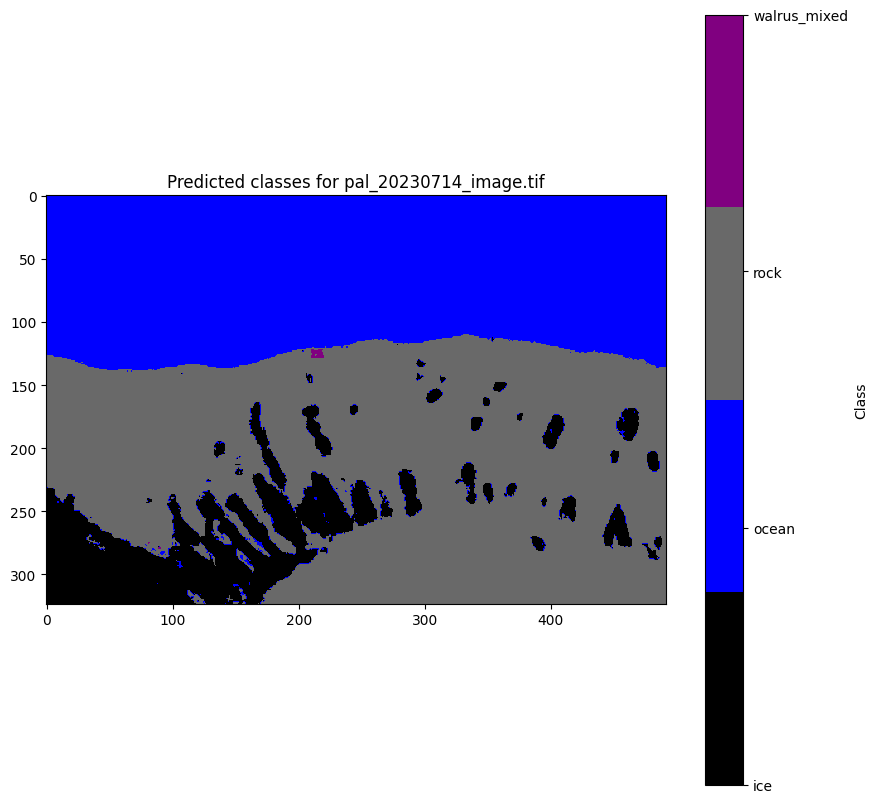

Labels present in pal_20230720_image.tif: ['ice', 'ocean', 'rock', 'walrus_mixed']


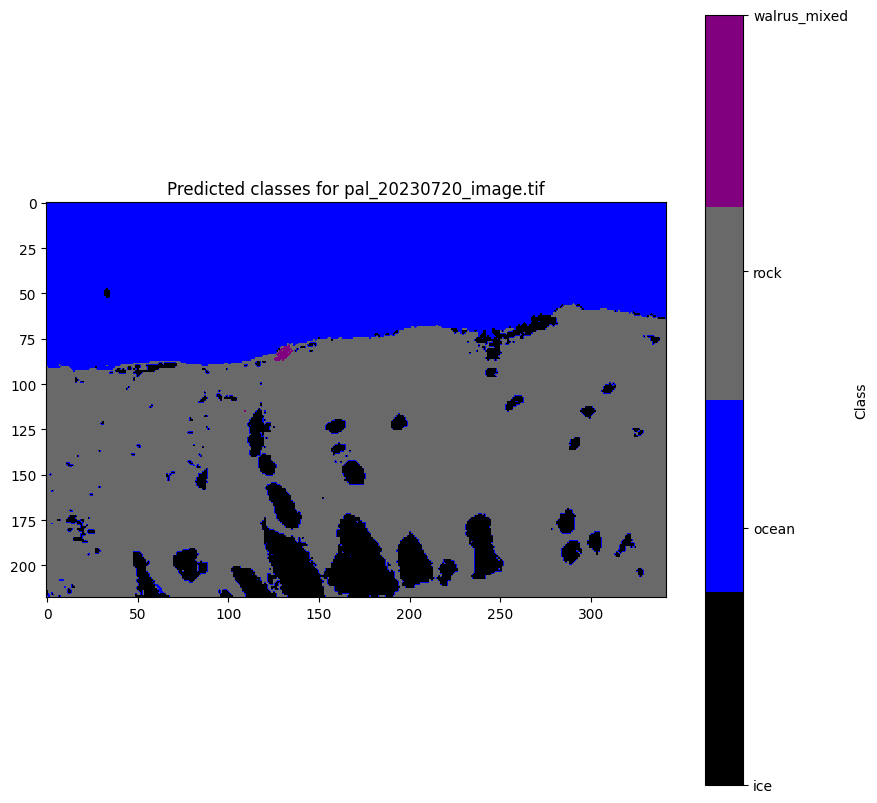

Labels present in pal_20230726_image.tif: ['ice', 'ocean', 'rock', 'walrus_mixed']


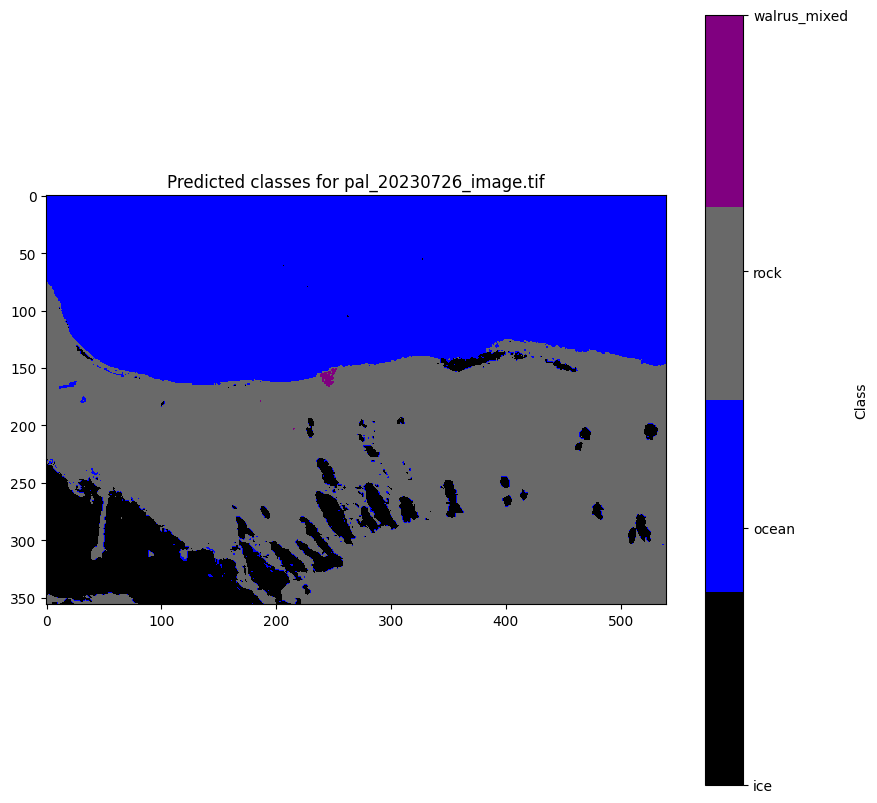

In [65]:
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model)


# Define a color map for the labels
label_colors = {'ice': 'black', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'purple', 'freshwater': 'cyan', 'ocean': 'blue'}
# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
    
    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()


SARS

In [72]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\island_by_island\\sars_image"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\island_by_island\\sars_train"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")

In [73]:

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None


# Create a dictionary to store paired image and shapefile paths
file_pairs = {}
# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    # Extract island name and date from file name
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    # Find corresponding shapefile
    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    # Only one matching shapefile for each image
    shapefile_path = matching_shapefiles[0]

    # Add the pair to the dictionary
    file_pairs[image_path] = shapefile_path

# Print the paired files to verify
for image_path, shapefile_path in file_pairs.items():
    print(f"Image: {image_path} | Shapefile: {shapefile_path}")

Image: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\sars_image\sars_20230714_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\sars_train\sars_20230714_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\sars_image\sars_20230803_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\sars_train\sars_20230803_train.shp


In [74]:
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    
    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']
        
        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
    
    return np.array(features), np.array(labels)

features = []
labels = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)

features = np.vstack(features)
labels = np.hstack(labels)

In [75]:
# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)
# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [76]:
# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

         ice       0.99      0.99      0.99      1188
       ocean       1.00      1.00      1.00     28619
walrus_mixed       1.00      0.58      0.74        24

    accuracy                           1.00     29831
   macro avg       1.00      0.86      0.91     29831
weighted avg       1.00      1.00      1.00     29831


Labels present in sars_20230714_image.tif: ['ice', 'ocean', 'walrus_mixed']


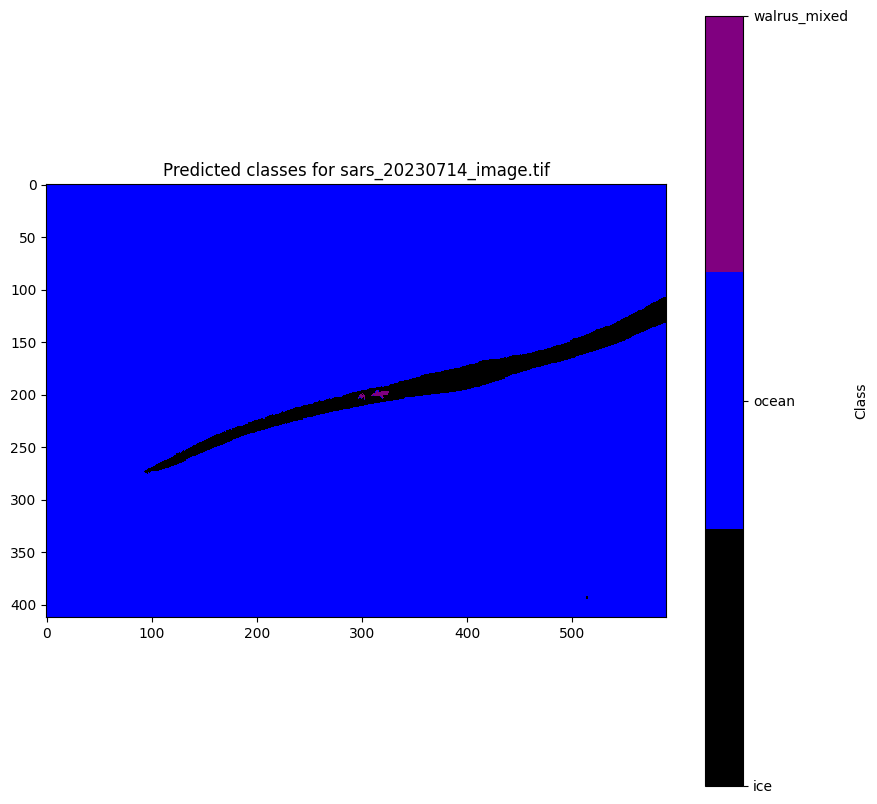

Labels present in sars_20230803_image.tif: ['ice', 'ocean', 'walrus_mixed']


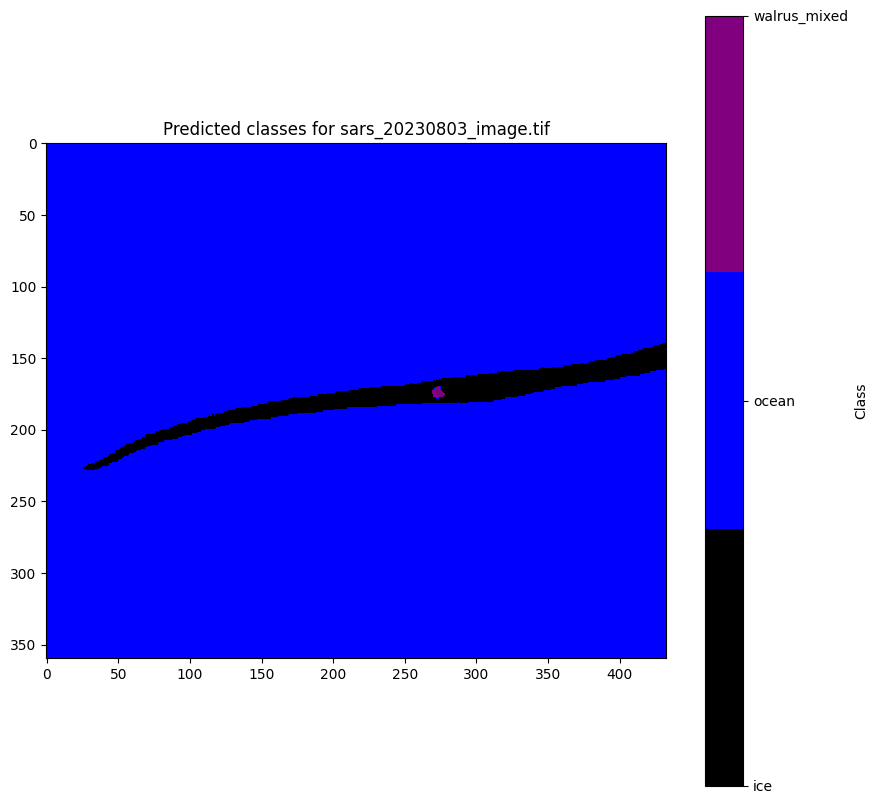

In [77]:
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model)


# Define a color map for the labels
label_colors = {'ice': 'black', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'purple', 'freshwater': 'cyan', 'ocean': 'blue'}
# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
    
    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()


TOR

In [78]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\island_by_island\\tor_image"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\island_by_island\\tor_train"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")

In [79]:

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None


# Create a dictionary to store paired image and shapefile paths
file_pairs = {}
# Pair image and shapefile paths based on filenames
for image_path in image_paths:
    # Extract island name and date from file name
    island, date = extract_island_and_date(os.path.basename(image_path))
    if island is None or date is None:
        print(f"Failed to extract island and date from {image_path}")
        continue

    # Find corresponding shapefile
    matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
    if not matching_shapefiles:
        print(f"No matching shapefile found for {image_path}")
        continue

    # Only one matching shapefile for each image
    shapefile_path = matching_shapefiles[0]

    # Add the pair to the dictionary
    file_pairs[image_path] = shapefile_path

# Print the paired files to verify
for image_path, shapefile_path in file_pairs.items():
    print(f"Image: {image_path} | Shapefile: {shapefile_path}")

Image: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\tor_image\tor_20230801_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\tor_train\tor_20230801_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\tor_image\tor_20230824_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\tor_train\tor_20230824_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\tor_image\tor_20230901_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\tor_train\tor_20230901_train.shp
Image: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\tor_image\tor_20230902_image.tif | Shapefile: C:\Users\Student\Documents\101_walrus_data\train\island_by_island\tor_train\tor_20230902_train.shp


In [80]:
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    
    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']
        
        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
    
    return np.array(features), np.array(labels)

features = []
labels = []

for image_path, shapefile_path in file_pairs.items():
    img_features, img_labels = extract_features_labels(image_path, shapefile_path)
    features.append(img_features)
    labels.append(img_labels)

features = np.vstack(features)
labels = np.hstack(labels)

In [81]:
# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)
# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [82]:
# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

  freshwater       0.97      0.94      0.96      1069
         ice       0.99      1.00      0.99     15275
       ocean       1.00      1.00      1.00     37900
        rock       0.80      0.34      0.48       230
walrus_mixed       1.00      0.70      0.82        47
 walrus_pure       0.77      0.91      0.83        11

    accuracy                           0.99     54532
   macro avg       0.92      0.82      0.85     54532
weighted avg       0.99      0.99      0.99     54532


Labels present in tor_20230801_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


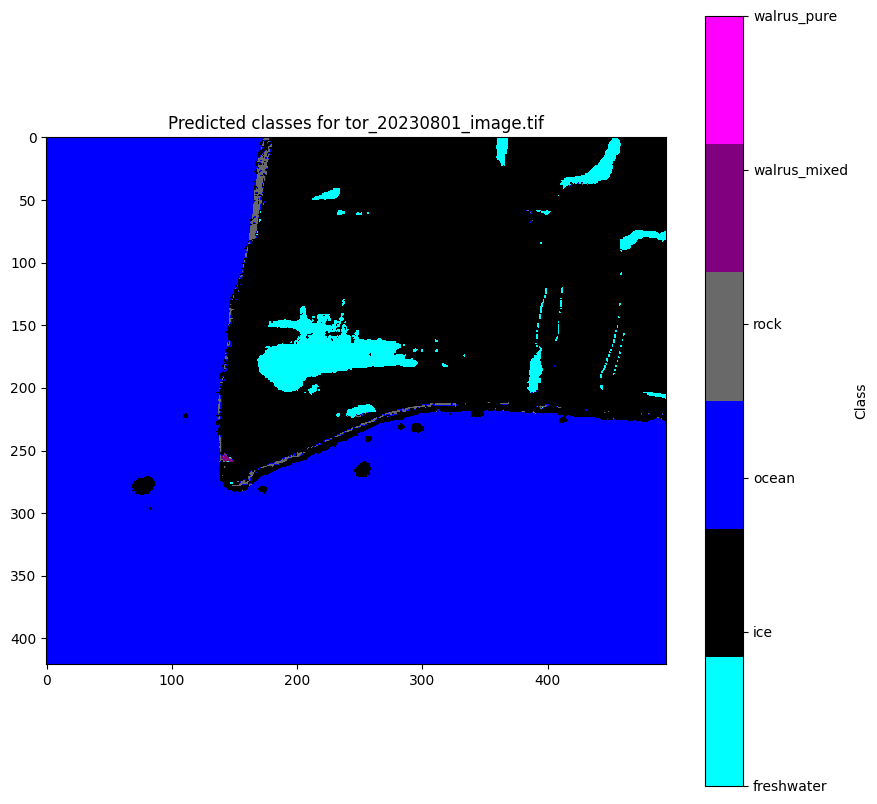

Labels present in tor_20230824_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


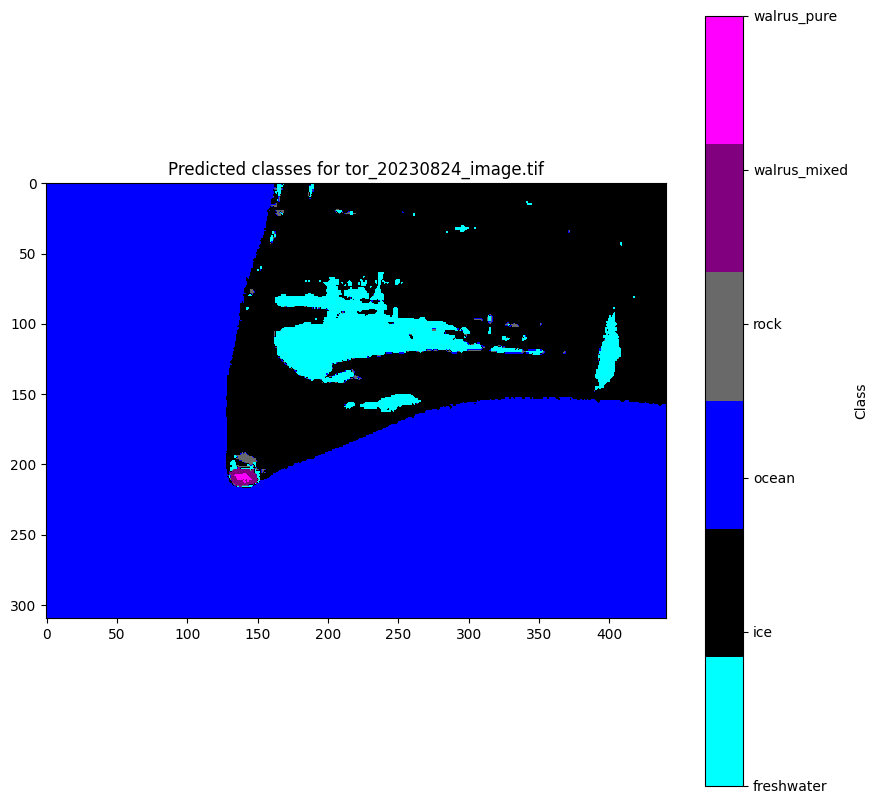

Labels present in tor_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


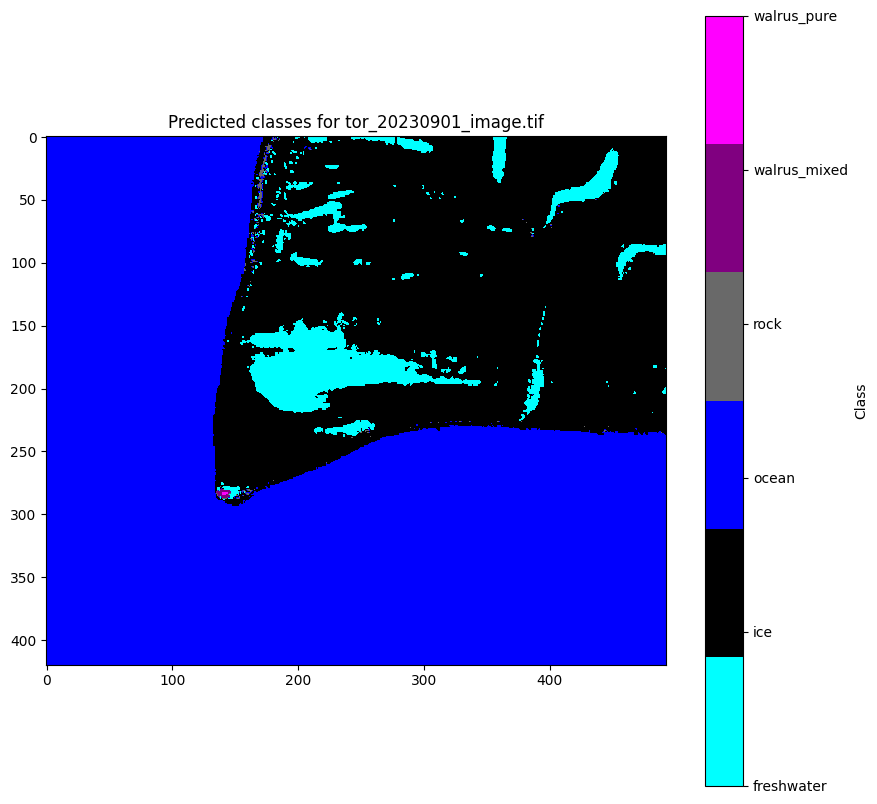

Labels present in tor_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


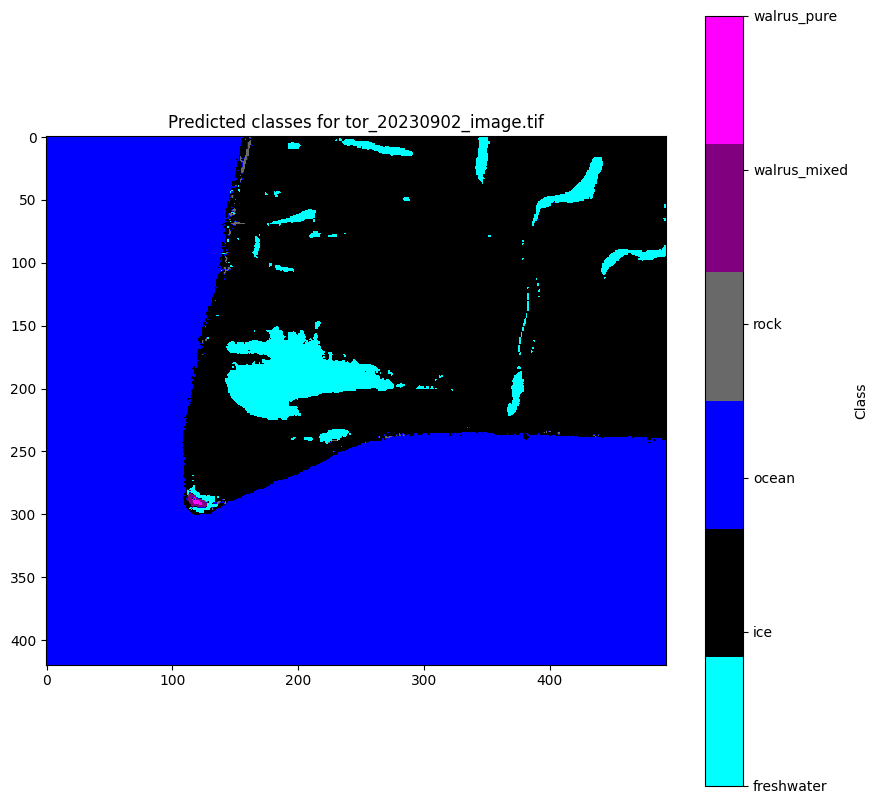

In [83]:
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model)


# Define a color map for the labels
label_colors = {'ice': 'black', 'rock': 'dimgray', 'walrus_pure': 'fuchsia', 'walrus_mixed': 'purple', 'freshwater': 'cyan', 'ocean': 'blue'}
# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
    
    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()
